In [142]:
''' 
    This code is developed for the Python workshop at the Winter School in Astronomy
    
    @Author : Sayantan Auddy
    Created : 7 Feb 2017

'''
import numpy as np                        # Importing the numerical function numpy
import matplotlib.pyplot as plt           # Importing the matplotlib for plotting

# Scipy is scientific python 
from scipy.special import erfc

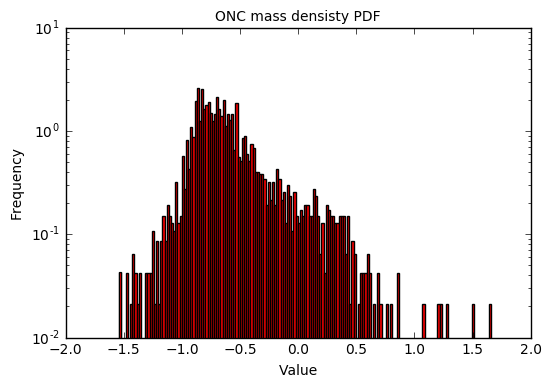

In [167]:
# %matplotlib qt
%matplotlib inline

# read the data file in fp

# fp = open ("V4t_256_19.0.dat",'r')
fp = open ("ONC.dat",'r')
# Declaring an empty list to store the data from the .dat file

mass =[]

# Reading the data from the .dat file line by line
# please refer to the link for details  
# http://stackoverflow.com/questions/4071396/split-by-comma-and-strip-whitespace-in-python

for line in fp:
    #print(line.strip().split())
    #print(line.strip())
    t = line.strip().split()
    for value in t:
        mass.append(float(value))         # the func append helps to modify the array storage on each iteration

fp.close()                                # closing the file after it reads in the data *important 
mass_array = (np.asarray(mass))           # # to convert rho python list to numpy array list for easy manipulation

# Visualisng the nature of the data by ploting a histogram

binsize = 173                              # declaring the bin size for the histogram
plt.hist(np.log10(mass_array),binsize,normed=1,facecolor='red',cumulative=False)     # Binning in log(m). 
# plt.xlim(min(np.log(mass_array))-0.5,max(np.log(mass_array))+0.5) # the limit of the x axis
# plt.ylim(0,6000)                        # y axis limit
plt.yscale('log')                         # log scale on the y axis
plt.title ("ONC mass densisty PDF",fontsize=10)
plt.xlabel("Log (mass)")
plt.ylabel("Frequency")
plt.show()

/Users/Sayantan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10


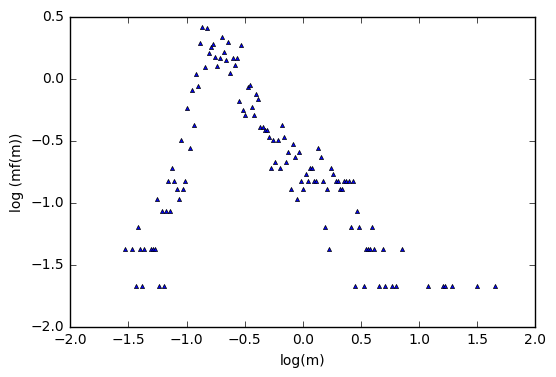

In [168]:
# To fit the histogram using the least square method
# this gives the frequency and the edges of the bins

# bincount,bin_edge = np.histogram(mass,binsize) # important to note we bin in dm
bincount,bin_edge = np.histogram(np.log10(mass_array),binsize,normed=1) # important to note we bin in dlog(m)

# bincenter is the value for the center of each bins
bincenter = (bin_edge[1:]+bin_edge[:-1])/2.0
xdata=bincenter[:]
ydata=np.log10(bincount[:])
# plt.ylim(10**-1,10**3)
plt.ylabel('log (mf(m))')
plt.xlabel('log(m)')
plt.plot(xdata,ydata,'^',markersize=3)
# plt.yscale('log')

The objective is to fit a Fucntion to the above data set for analysing the slope of the power law tail. 
We shall try to fit MLP (Basu et al 2015)
The MLP function is define as:

f(m) = 

In [169]:
# Declaring the MLP function as f(m)

# def MLP(x,alpha,mu0,sigma0):
def MLPMLEfit(params):
    alpha,mu0,sigma0=params
    x = mass_array
    p1=(alpha/2.0)*np.exp(alpha*mu0+((alpha*sigma0)**2)/2.0)
    p2=x**(-(1+alpha))
    arg=(1.0/np.sqrt(2.0))*(alpha*sigma0-(np.log(x)-mu0)/sigma0)
    p3=erfc(arg)
    p = p1*p2*p3;
    return sum(-np.log(p)) 
#     return(p)

########################################################################

def MLP(x,*params):
    alpha,mu0,sigma0=params
    p1=(alpha/2.0)*np.exp(alpha*mu0+((alpha*sigma0)**2)/2.0)
    p2=x**(-(alpha))
    arg=(1.0/np.sqrt(2.0))*(alpha*sigma0-(np.log(x)-mu0)/sigma0)
    p3=erfc(arg)
    p = np.log10(p1*p2*p3);
#     return sum(-np.log(p)) 
    return(p)

In [221]:
from scipy.optimize import curve_fit
fitParams,fitCov=curve_fit(MLP,xdata,ydata,bounds=(-4, [3., -3., 1.]))
print('alpha=%f\n'%(fitParams[0]))
print('mu_0=%f\n'%(fitParams[1]))
print('sigma_0=%f\n'%(fitParams[2]))

In [170]:
'''
For optimization we shall use
scipy.optimize.differential_evolution
For detials: 
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.differential_evolution.html

'''
# We want to find the optimized value for the parameters alpha, mu0 and sigma0 for the best
# fit MLP fucntion.

from scipy.optimize import differential_evolution
# defining the possible bounds for the values of alpha, mu0 and sigma0
bounds = [(1, 5), (-3, 1),(0.01,2)]

np.random.seed(1)
result = differential_evolution(MLPMLEfit, bounds)
# result.x, result.fun
print("global minimum: x = [%.3f, %.3f,%.3f], f(x0) = %.3f\n" % (result.x[0], result.x[1],result.x[2],result.fun))
print('alpha  = %.3f\n'%(result.x[0]))
print('mu0    =%.3f\n'%(result.x[1]))
print('sigma_0= %.3f\n'%(result.x[2]))

/Users/Sayantan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


global minimum: x = [1.403, -2.084,0.348], f(x0) = -789.658

alpha  = 1.403

mu0    =-2.084

sigma_0= 0.348



/Users/Sayantan/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


In [171]:
'''
For optimization we shall use
scipy.optimize import basinhopping
For detials: 
https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.basinhopping.html

'''
from scipy.optimize import basinhopping

# intial guess values of the parameter alpha, mu0, sigma0
x0 = [3., 0.1,0.1]

# defining the possible bounds for the values of alpha, mu0 and sigma0

xmin = [1.,-3.,0.]          # lower bound
xmax = [5.,1., 1.]          # upper bound

# rewrite the bounds in the way required by L-BFGS-B
bounds = [(low, high) for low, high in zip(xmin, xmax)]

minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)

ret = basinhopping(MLPMLEfit,x0,minimizer_kwargs=minimizer_kwargs,niter=200,disp=0,niter_success=None)

print("global minimum: x = [%.3f, %.3f,%.3f], f(x0) = %.3f\n" % (ret.x[0], ret.x[1],ret.x[2],ret.fun))
print('alpha  = %.3f\n'%(ret.x[0]))
print('mu0    =%.3f\n'%(ret.x[1]))
print('sigma_0= %.3f\n'%(ret.x[2]))

/Users/Sayantan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in true_divide
/Users/Sayantan/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/Users/Sayantan/anaconda/lib/python3.5/site-packages/scipy/optimize/optimize.py:628: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


global minimum: x = [1.421, -2.071,0.351], f(x0) = -790.021

alpha  = 1.421

mu0    =-2.071

sigma_0= 0.351



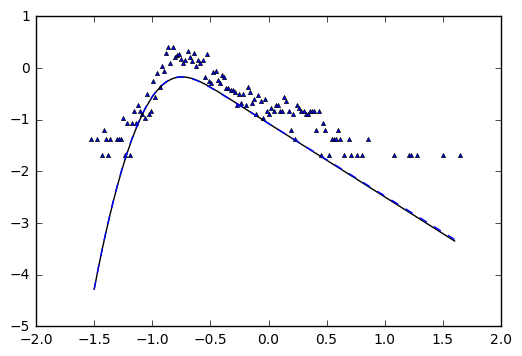

In [173]:
# Plotting the MLP with the best fit parameter along wiht the ONC data points

# using the best fit parmameters from differential evolution optimisation
# params = [result.x[0],result.x[1],result.x[2]]
# using the best fit parameters from the basinhopping optimisation
params_dff = [ret.x[0],ret.x[1],ret.x[2]]
params_bh = result.x[0],result.x[1],result.x[2]
xarray = np.logspace(-1.5,1.6,1000)
plt.plot(xdata,ydata,'^',markersize=3)
plt.plot(np.log10(xarray),MLP(xarray,*params_dff),'k',np.log10(xarray),MLP(xarray,*params_bh),'b--')
# plt.yscale('log')
# plt.xscale('log')
plt.plot()
plt.show()

In [97]:
print(np.logspace(-.05,1.4,10))

[  0.89125094   1.29154967   1.87163959   2.71227258   3.93046963
   5.69581081   8.25404185  11.96128333  17.33360473  25.11886432]
